# sequence prediction sandbox


In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# create all possible n-mers for 8
seqs8 = [''.join(x) for x in product(['A','C','G','T'], repeat=8)]
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [4]:
# if you want to down select
seqs8_200 = u.downselect_list(seqs8,200)

In [5]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
def score_seqs(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
                  
def score_seqs_motif(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
    

In [6]:
mer8 = score_seqs(seqs8)
mer8.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


In [7]:
mer8_motif = score_seqs_motif(seqs8)


In [8]:
mer8_motif[mer8['seq']=='TGCGTTTT']

,seq,score
59135,TGCGTTTT,2.5


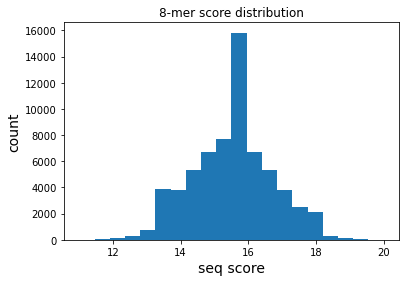

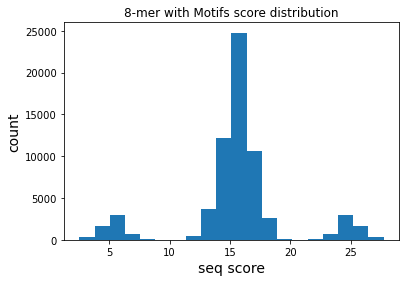

In [9]:
plt.hist(mer8['score'].values,bins=20)
plt.title("8-mer score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

plt.hist(mer8_motif['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

### Define some basic model archs for Linear and CNN

In [10]:
class DNA_Linear_Shallow(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        
        #print("og shape?",xb.shape)
        #xb = xb.flatten()
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        #print("flattened shape?",xb.shape)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_Linear_Deep(nn.Module):
    def __init__(self, seq_len,h1_size):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    

    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

In [11]:
def plot_train_test_hist(train_df, test_df,bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label="train")
    plt.hist(test_df['score'].values,bins=bins,label='test')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()


def quick_test8(model, oracle):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        #u.quick_seq_pred(model, seqs, oracle)
        quick_seq_pred(model, seqs, oracle)
        print()

## try defining flexible model class with Optuna

In [34]:
# defining a deep linear model with Optuna
class DNA_Linear_Opt(nn.ModuleList):
    def __init__(self, trial, seq_len):
        super().__init__()
        
        self.seq_len = seq_len
        # Where the layers and dropouts will be stacked
        self.layers = []
        self.dropouts = []
        
        # Given a trial, takes the suggested number of 
        # layers as well as the dropout value  
        n_layers = trial.suggest_int('n_layers', 1, 3)
        dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
        
        # input sequence size
        input_dim = 4*seq_len
        
        # Given the suggested number of layers, proceeds by
        # stacking layer by layer. Likewise the number of internal
        # units is a value taken from the current trial suggestion
        for layer in range(n_layers):
            output_dim = trial.suggest_int(f"output_dim_{layer}", 1, 100)#, log=True)
            
            self.layers.append(nn.Linear(input_dim, output_dim))
            self.dropouts.append(nn.Dropout(dropout))

            input_dim = output_dim
        
        # The last layer is added to the stack.
        self.layers.append(nn.Linear(input_dim, 1))
        self.dropouts.append(nn.Dropout(0))
        
        # PyTorch needs each layer, dropout, etc to be defined as an instance 
        # variable of the class. E.g. self.layer_1 = nn.Linear(in, out)
        # Thus we need to create such instance variable from the list of stacked 
        # layers and dropouts with the "setattr" method.
        for idx, layer in enumerate(self.layers):
            setattr(self, f"fc_{idx}", layer)

        for idx, dropout in enumerate(self.dropouts):
            setattr(self, f"dr_{idx}", dropout)
            
    def forward(self, xb):

        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        
        x = xb #?
        
        for layer, dropout in zip(self.layers, self.dropouts):
            x = layer(x)
            x = F.relu(x)
            x = dropout(x)
        
        #out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return x
    

# Try with 8 mers

# Single task Regression with Motifs
### Linear Model

In [12]:
# mer8motif_train_df.to_csv("mer8motif_train_df.tsv",sep='\t')
# mer8motif_test_df.to_csv("mer8motif_test_df.tsv",sep='\t')

In [13]:
#mer8motif_train_df.head()

In [13]:
mer8motif_train_dl, \
mer8motif_test_dl, \
mer8motif_train_df, \
mer8motif_test_df = u.build_dataloaders_single(mer8_motif, batch_size=13)

In [14]:
mer8motif_train_df['oh'].values[0].shape

(8, 4)

In [15]:
# # inspect some stuff about a batch
# for xb, yb in mer8motif_train_dl:
#     break
    
# print(xb)
# print(xb.permute(0,2,1).unsqueeze(1).shape)
# xb.permute(0,2,1)

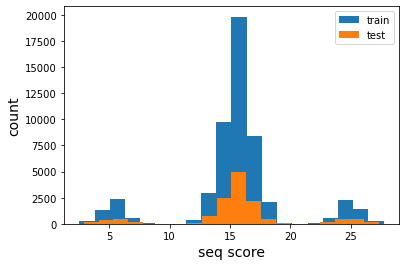

In [16]:
plot_train_test_hist(mer8motif_train_df, mer8motif_test_df,bins=20)

# TEMP FUNCS

In [17]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(device)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
    loss = loss_func(xb_out, yb.float())

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, test_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    test_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        #print("TRAIN")
        model.train()
        ts = []
        ns = []
        # collect train loss; provide opt so backpropo happens
        for xb, yb in train_dl:
            # put on GPU
            xb, yb = xb.to(device),yb.to(device)
            
            t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
            ts.append(t)
            ns.append(n)
        train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
        train_losses.append(train_loss)
        
        #print("EVAL")
        model.eval()
        with torch.no_grad():
            ts = [] # test losses
            ns = [] # batch sizes
            for xb, yb in test_dl:
                # put on GPU
                xb, yb = xb.to(device),yb.to(device)

                test_loss, num_in_batch = loss_batch(model, loss_func, xb, yb)
                ts.append(test_loss)
                ns.append(num_in_batch)
#             losses, nums = zip(
#                 # loop through test batches
#                 # returns loss calc for test set batch size
#                 # unzips into two lists
#                 *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
#                 # Note: no opt provided, backprop won't happen
#             )
        # Gets average MSE loss across all batches (may be of diff sizes, hence the multiply)
        #print("losses", losses)
        #print("nums", nums)
        #test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)

        print(epoch, test_loss)
        test_losses.append(test_loss)

    return train_losses, test_losses

def run_model(train_dl,test_dl, model, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    loss_func = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

## Optuna objective functions
study.optimize seems to only take trial as an input and automatically. In order to pass epochs and train/test data loaders, I think I have to wrap it in an extra Model class? Then calls the Model's self.objective?

In [115]:
class OptWrap:
    '''
    Adapted from: 
    https://github.com/FernandoLpz/Optuna-Sklearn-PyTorch/blob/master/optuna_pytorch.py
    
    Optuna needs to call "study.optimize" on a function with no inputs other 
    than trial... trying to make that happen here...
    '''
    
    def __init__(self, 
                 name, 
                 model_class, 
                 seq_len, 
                 epochs, 
                 loss_func, 
                 train_loader, 
                 test_loader
                ):
        self.name = name
        self.model_class = model_class
        self.seq_len = seq_len
        self.epochs = epochs
        self.loss_func = loss_func
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.train_loss_list = []
        self.test_loss_list = []
        self.opt_wrap_opt_count = 0
        
    def optimize(self, trial):
        # i dunno, just count to see what happens?
        self.opt_wrap_opt_count += 1 
        if self.opt_wrap_opt_count >1:
            print(f"WARNING: OptWrap for {self.name} has run optimize {self.opt_wrap_opt_count} times??")
        
        # Initialize model with the current trial
        model = self.model_class(trial, self.seq_len).to(device)
        train_losses = []
        test_losses = []
        # ^^ Do these need to be reset? Will they ever but updated multiple times
        
        # Define space search for training settings
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
        learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
        opt = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
        
        # Starts training phase
        for epoch in range(self.epochs):
            
            # Set model in training model
            model.train()
            ts = [] # train losses
            ns = [] # batch sizes
            # collect train loss; provide opt so backpropo happens
            for xb, yb in self.train_loader:
                # put on GPU
                xb, yb = xb.to(device),yb.to(device)

                t, n = loss_batch(model, self.loss_func, xb, yb, opt=opt)
                ts.append(t)
                ns.append(n)
            train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
            
            
            # set the model in eval model
            model.eval()
            with torch.no_grad():
                ts = [] # test losses
                ns = [] # batch sizes
                for xb, yb in self.test_loader:
                    # put on GPU
                    xb, yb = xb.to(device),yb.to(device)

                    test_loss, num_in_batch = loss_batch(model, self.loss_func, xb, yb)
                    ts.append(test_loss)
                    ns.append(num_in_batch)
            test_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
            print(epoch, test_loss)
            
            # I don't think these are needed... just return to
            # Optuna which value we want minimized...? But hang 
            # on just in case
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            #trial.report(accuracy, epoch)
            trial.report(test_loss, epoch)

            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        
        # return history of this trials training/test loss?
        self.train_loss_list.append(train_losses)
        self.test_loss_list.append(test_losses)
        
        # return final test loss?? or best test loss?? 
        return test_loss
            
        
        

# def OPT_objective(trial, epochs, model, loss_func, opt, train_dl, test_dl):
#     '''
#     Fit the model params to the training data, eval on unseen data.
#     Loop for a number of epochs and keep train of train and val losses 
#     along the way
#     '''
#     # keep track of losses
#     train_losses = []    
#     test_losses = []
    
#     # loops through epochs
#     for epoch in range(epochs):
#         #print("TRAIN")
#         model.train()
#         ts = []
#         ns = []
#         # collect train loss; provide opt so backpropo happens
#         for xb, yb in train_dl:
#             # put on GPU
#             xb, yb = xb.to(device),yb.to(device)
            
#             t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
#             ts.append(t)
#             ns.append(n)
#         train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
#         train_losses.append(train_loss)
        
#         #print("EVAL")
#         model.eval()
#         with torch.no_grad():
#             ts = [] # test losses
#             ns = [] # batch sizes
#             for xb, yb in test_dl:
#                 # put on GPU
#                 xb, yb = xb.to(device),yb.to(device)

#                 test_loss, num_in_batch = loss_batch(model, loss_func, xb, yb)
#                 ts.append(test_loss)
#                 ns.append(num_in_batch)
# #             losses, nums = zip(
# #                 # loop through test batches
# #                 # returns loss calc for test set batch size
# #                 # unzips into two lists
# #                 *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
# #                 # Note: no opt provided, backprop won't happen
# #             )
#         # Gets average MSE loss across all batches (may be of diff sizes, hence the multiply)
#         #print("losses", losses)
#         #print("nums", nums)
#         #test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
#         test_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
        
#         print(epoch, test_loss)
#         test_losses.append(test_loss)

#     return train_losses, test_losses

# def run_model(train_dl,test_dl, model, lr=0.01, epochs=20):
#     '''
#     Given data and a model type, run dataloaders with MSE loss and SGD opt
#     '''
#     # define loss func and optimizer
#     loss_func = torch.nn.MSELoss() 
#     optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
#     # run the training loop
#     train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
#     #return model, train_losses, test_losses
#     return train_losses, test_losses

## Shallow Linear

0 12.881741964047661
1 12.763709161461291
2 12.7452597361914
3 12.776268854432619
4 12.759200510470867
5 12.79019094706673
6 12.752814379704592
7 12.778339532624305
8 12.737042826579627
9 12.714506262571739
10 12.779338293243626
11 12.789914414945956
12 12.765776715401945
13 12.85262468763703
14 12.727622440567385
15 12.872211142851516
16 12.778610376775864
17 12.841088471195848
18 12.75085607832221
19 12.798593138471624


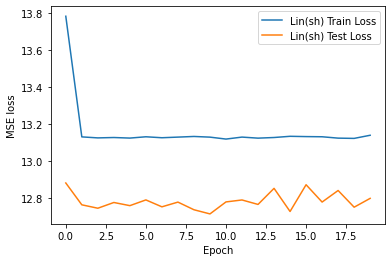

In [19]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_s = DNA_Linear_Shallow(seq_len)
mer8motif_model_lin_s.to(device)

mer8motif_train_losses_lin_s, mer8motif_test_losses_lin_s = run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lin_s
)

# to plot loss
mer8motif_lin_s_data_label = list(zip([mer8motif_train_losses_lin_s,
                                       mer8motif_test_losses_lin_s], 
                                      ['Lin(sh) Train Loss',
                                       'Lin(sh) Test Loss']))
u.quick_loss_plot(mer8motif_lin_s_data_label)

In [20]:
dna = "GGGGGGGG"
dna_oh = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).float().to(device)
mer8motif_model_lin_s(dna_oh)

tensor([[7.2132]], device='cuda:0', grad_fn=<AddmmBackward>)

In [21]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin_s,oracle_8mer_motif)

AAAAAAAA: pred:23.222 actual:20.000 (-3.222)
CCCCCCCC: pred:13.344 actual:17.000 (3.656)
GGGGGGGG: pred:7.213 actual:14.000 (6.787)
TTTTTTTT: pred:17.711 actual:11.000 (-6.711)

AACCAACA: pred:18.814 actual:18.875 (0.061)
CCGGCGCG: pred:10.204 actual:5.500 (-4.704)
GGGTAAGG: pred:14.119 actual:15.125 (1.006)
TTTCGTTT: pred:14.597 actual:12.125 (-2.472)
TGTAATAC: pred:19.347 actual:15.500 (-3.847)

TATAAAAA: pred:22.050 actual:27.750 (5.700)
CCTATCCC: pred:16.481 actual:25.875 (9.394)
GTATGGGG: pred:12.276 actual:24.000 (11.724)
TTTATTTT: pred:18.078 actual:22.125 (4.047)

AAGCGAAA: pred:16.834 actual:8.125 (-8.709)
CGCGCCCC: pred:12.151 actual:6.250 (-5.901)
GGGCGGGG: pred:8.093 actual:4.375 (-3.718)
TTGCGTTT: pred:12.732 actual:2.500 (-10.232)

ATATGCGA: pred:15.348 actual:15.875 (0.527)
TGCGTATT: pred:14.512 actual:13.625 (-0.887)



## Deep Linear

0 7.0355842728002935
1 4.255000521128484
2 2.7197532888944096
3 2.0601862507815727
4 1.3957770553951516
5 1.0354233034930471
6 1.017456814379573
7 0.8598703306440013
8 0.756454254262977
9 0.7708546892706581
10 0.6932377083136663
11 1.6151002785840691
12 0.6809334647090043
13 0.6330302824488784
14 0.6965707763819196
15 0.6318837905147471
16 0.6741603235513777
17 0.6174175359762303
18 0.7178353779879051
19 0.6798389524950108


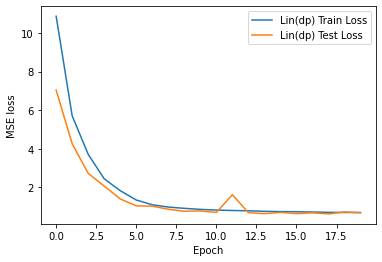

In [22]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_d = DNA_Linear_Deep(seq_len,hidden_layer_size)
mer8motif_model_lin_d.to(device)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lin_d
)

# to plot loss
mer8motif_lin_d_data_label = list(zip([mer8motif_train_losses_lin_d,
                                       mer8motif_test_losses_lin_d], 
                                      ['Lin(dp) Train Loss',
                                       'Lin(dp) Test Loss']))
u.quick_loss_plot(mer8motif_lin_d_data_label)

In [23]:
dna = "GGGGGGGG"
dna_oh = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).float().to(device)
mer8motif_model_lin_d(dna_oh)

tensor([[14.5980]], device='cuda:0', grad_fn=<ReluBackward1>)

In [24]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin_d,oracle_8mer_motif)

AAAAAAAA: pred:20.589 actual:20.000 (-0.589)
CCCCCCCC: pred:17.440 actual:17.000 (-0.440)
GGGGGGGG: pred:14.598 actual:14.000 (-0.598)
TTTTTTTT: pred:11.242 actual:11.000 (-0.242)

AACCAACA: pred:19.191 actual:18.875 (-0.316)
CCGGCGCG: pred:0.000 actual:5.500 (5.500)
GGGTAAGG: pred:15.641 actual:15.125 (-0.516)
TTTCGTTT: pred:11.833 actual:12.125 (0.292)
TGTAATAC: pred:16.178 actual:15.500 (-0.678)

TATAAAAA: pred:25.785 actual:27.750 (1.965)
CCTATCCC: pred:25.519 actual:25.875 (0.356)
GTATGGGG: pred:24.513 actual:24.000 (-0.513)
TTTATTTT: pred:21.163 actual:22.125 (0.962)

AAGCGAAA: pred:9.274 actual:8.125 (-1.149)
CGCGCCCC: pred:6.316 actual:6.250 (-0.066)
GGGCGGGG: pred:4.971 actual:4.375 (-0.596)
TTGCGTTT: pred:3.128 actual:2.500 (-0.628)

ATATGCGA: pred:16.613 actual:15.875 (-0.738)
TGCGTATT: pred:13.388 actual:13.625 (0.237)



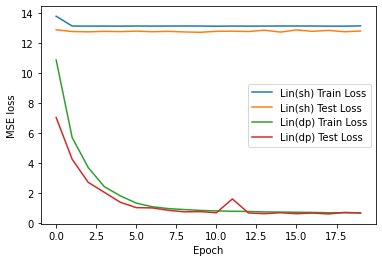

In [25]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label
)

## Optuna model

In [116]:
seq_len = len(mer8motif_train_df['seq'].values[0])
eps=10
loss_func = torch.nn.MSELoss()

ow = OptWrap(
    "DNA_Linear_Opt",
    DNA_Linear_Opt,
    seq_len,
    eps,
    loss_func,
    mer8motif_train_dl, 
    mer8motif_test_dl
)

In [117]:
ow.opt_wrap_opt_count

0

In [118]:
study = optuna.create_study(direction="minimize")

[I 2021-09-17 00:05:33,759] A new study created in memory with name: no-name-b8e92e3d-798f-49c4-a601-5548acb6f6a3


In [119]:
study.optimize(ow.optimize, n_trials=20)

0 258.5624000844993
1 258.5624000844993
2 258.5624000844993
3 258.5624000844993
4 258.5624000844993
5 258.5624000844993
6 258.5624000844993
7 258.5624000844993
8 258.5624000844993


[I 2021-09-17 00:06:15,108] Trial 0 finished with value: 258.5624000844993 and parameters: {'n_layers': 1, 'dropout': 0.3043176140361399, 'output_dim_0': 67, 'optimizer': 'SGD', 'lr': 0.08777798017053072}. Best is trial 0 with value: 258.5624000844993.


9 258.5624000844993
0 221.34376294488473
1 163.02603125557653
2 102.30141870088154
3 51.671910021121015
4 23.055629033694224
5 16.274568393176235
6 15.225810599456228
7 14.610625711953745
8 14.142150332856222


[I 2021-09-17 00:07:06,300] Trial 1 finished with value: 13.778069994104575 and parameters: {'n_layers': 1, 'dropout': 0.16144053693625027, 'output_dim_0': 18, 'optimizer': 'Adam', 'lr': 1.5422787945337784e-05}. Best is trial 1 with value: 13.778069994104575.


9 13.778069994104575
0 28.809435063395007
1 14.605127991457646
2 13.099156440986814
3 12.692867637862873
4 12.580421804345015
5 12.499923122021931
6 12.393131878341812
7 12.264196359059925
8 12.138102574613278


[I 2021-09-17 00:07:57,281] Trial 2 finished with value: 11.998295042712694 and parameters: {'n_layers': 1, 'dropout': 0.20246833846988294, 'output_dim_0': 84, 'optimizer': 'Adam', 'lr': 3.462342493340308e-05}. Best is trial 2 with value: 11.998295042712694.


9 11.998295042712694
0 202.63087262443773
1 129.48463340744325
2 54.77876611493657
3 22.615427999333487
4 18.911121942755432
5 17.864755362417775
6 17.200992373656966
7 16.45581215210793
8 15.971441593613427


[I 2021-09-17 00:08:41,985] Trial 3 finished with value: 15.699909850286572 and parameters: {'n_layers': 1, 'dropout': 0.3968442388789325, 'output_dim_0': 8, 'optimizer': 'RMSprop', 'lr': 3.546001206108884e-05}. Best is trial 2 with value: 11.998295042712694.


9 15.699909850286572
0 138.64793251018753
1 17.782392280669086
2 15.483994823914314
3 14.471279548410056
4 13.981226832465788
5 13.906840562038317
6 13.793815686639432
7 13.900863132218163
8 13.95519333299355


[I 2021-09-17 00:09:38,525] Trial 4 finished with value: 13.910889464469447 and parameters: {'n_layers': 2, 'dropout': 0.3030744854512476, 'output_dim_0': 8, 'output_dim_1': 44, 'optimizer': 'RMSprop', 'lr': 3.145347508914156e-05}. Best is trial 2 with value: 11.998295042712694.


9 13.910889464469447
0 159.01840106066604
1 16.376056522219635
2 14.872814426534525
3 14.008039840268296
4 13.488222003601512
5 13.167889063728266
6 12.973483331249115
7 12.86595814931782
8 12.789431614376694


[I 2021-09-17 00:10:16,983] Trial 5 finished with value: 12.75366979517295 and parameters: {'n_layers': 1, 'dropout': 0.13994185277757448, 'output_dim_0': 77, 'optimizer': 'SGD', 'lr': 1.4424678949312854e-05}. Best is trial 2 with value: 11.998295042712694.


9 12.75366979517295
0 11.530960655208764
1 9.815706982831239
2 7.910359281627078
3 6.124925300185641
4 5.413607174173102
5 4.702514452246456
6 4.368658192717232
7 4.310776049586687
8 4.267827598571887


[I 2021-09-17 00:10:55,703] Trial 6 finished with value: 4.1794276480671835 and parameters: {'n_layers': 1, 'dropout': 0.4134551657488188, 'output_dim_0': 40, 'optimizer': 'SGD', 'lr': 0.004129489980171384}. Best is trial 6 with value: 4.1794276480671835.


9 4.1794276480671835
0 18.095125703876032
1 15.254843099204766
2 14.174260453899386
3 13.552411468346598
4 13.46013112467602
5 13.303728944323286
6 13.067386677243704
7 13.083130754346268
8 13.02929928109418


[I 2021-09-17 00:11:42,710] Trial 7 finished with value: 12.9695061067728 and parameters: {'n_layers': 2, 'dropout': 0.42586453647051214, 'output_dim_0': 54, 'output_dim_1': 57, 'optimizer': 'SGD', 'lr': 1.4460336999012352e-05}. Best is trial 6 with value: 4.1794276480671835.


9 12.9695061067728
0 5.900738200673542
1 1.5650223560442567
2 1.419501258465605
3 1.0341644801920167
4 2.7005082330335957
5 1.3727207071499414
6 2.045241966307036
7 1.1857897757316962
8 1.0594805473581679


[I 2021-09-17 00:12:46,128] Trial 8 finished with value: 1.1953229562126197 and parameters: {'n_layers': 2, 'dropout': 0.28938837607345413, 'output_dim_0': 79, 'output_dim_1': 45, 'optimizer': 'Adam', 'lr': 0.005185920882926386}. Best is trial 8 with value: 1.1953229562126197.


9 1.1953229562126197
0 2.2916872832636517
1 1.2252962383923913
2 1.4122890527367247
3 1.1914204598941889
4 0.6480165396509808
5 0.9152239141010969
6 0.6364154889645338
7 0.7132194325803055
8 0.6075066669946687


[I 2021-09-17 00:13:33,632] Trial 9 finished with value: 0.9332110541879786 and parameters: {'n_layers': 2, 'dropout': 0.16122473377888635, 'output_dim_0': 29, 'output_dim_1': 86, 'optimizer': 'SGD', 'lr': 0.007843592109113978}. Best is trial 9 with value: 0.9332110541879786.


9 0.9332110541879786


[I 2021-09-17 00:13:39,376] Trial 10 pruned. 


0 258.5624000844993


[I 2021-09-17 00:13:47,135] Trial 11 pruned. 


0 258.5624000844993
0 7.975294826898427
1 6.105589825740703
2 5.6828997896704
3 6.0920088138882615
4 7.946772579921067
5 6.524125800537088
6 5.548724480277978
7 5.742724458343979
8 5.518074053453624


[I 2021-09-17 00:14:51,268] Trial 12 finished with value: 4.137804664164409 and parameters: {'n_layers': 2, 'dropout': 0.4948503045966419, 'output_dim_0': 58, 'output_dim_1': 60, 'optimizer': 'Adam', 'lr': 0.009005610363441162}. Best is trial 9 with value: 0.9332110541879786.


9 4.137804664164409
0 11.3405943541382
1 10.39572012596353
2 9.751595819009161
3 9.046361213023065
4 7.704491499041798
5 6.225966627336982
6 4.362739583286964
7 2.8834708746082724
8 2.0627191920091477


[I 2021-09-17 00:15:55,314] Trial 13 finished with value: 1.4466240772187964 and parameters: {'n_layers': 2, 'dropout': 0.24816976337814756, 'output_dim_0': 36, 'output_dim_1': 98, 'optimizer': 'Adam', 'lr': 0.00042267339904499663}. Best is trial 9 with value: 0.9332110541879786.


9 1.4466240772187964
0 10.166046713906015
1 7.2797238028173155
2 4.149521332558132
3 1.8679252394728265
4 1.215083010884631
5 0.8149114435832512
6 1.3816261596927693
7 0.851980515952095
8 0.8593400431069925


[I 2021-09-17 00:17:03,069] Trial 14 finished with value: 0.672994939065267 and parameters: {'n_layers': 3, 'dropout': 0.341818371626372, 'output_dim_0': 98, 'output_dim_1': 33, 'output_dim_2': 82, 'optimizer': 'RMSprop', 'lr': 0.0005650847203265138}. Best is trial 14 with value: 0.672994939065267.


9 0.672994939065267
0 12.986719229289006
1 11.994941935093257
2 11.117486151473567
3 10.280647083953237
4 9.297869962446567
5 8.705148511751236
6 8.320587596293626
7 7.636310679208843
8 6.863353617819009


[I 2021-09-17 00:18:11,653] Trial 15 finished with value: 6.190447209635394 and parameters: {'n_layers': 3, 'dropout': 0.35667009540111694, 'output_dim_0': 24, 'output_dim_1': 24, 'output_dim_2': 89, 'optimizer': 'RMSprop', 'lr': 0.0002885229225667868}. Best is trial 14 with value: 0.672994939065267.


9 6.190447209635394
0 14.376922580502475


[I 2021-09-17 00:18:25,520] Trial 16 pruned. 


1 14.3478349044869
0 9.558293279775366
1 8.305437414392234
2 4.555820463464542
3 2.8060539296606817
4 1.3784355610929633
5 1.289039183402338
6 1.101471734023177
7 1.1275708085817828
8 1.513748655349771


[I 2021-09-17 00:19:33,513] Trial 17 finished with value: 1.0891718366898102 and parameters: {'n_layers': 3, 'dropout': 0.18767512058747773, 'output_dim_0': 42, 'output_dim_1': 25, 'output_dim_2': 56, 'optimizer': 'RMSprop', 'lr': 0.0009678734379567448}. Best is trial 14 with value: 0.672994939065267.


9 1.0891718366898102
0 12.427021666238103
1 11.577731896454436
2 10.874942998479407
3 9.97983608614718
4 9.15746364421258
5 8.553038835298153
6 8.02164138759423


[I 2021-09-17 00:20:19,421] Trial 18 pruned. 


7 7.712588343936422
0 12.04623121024997
1 8.602793841776522
2 7.12375673434794
3 6.615033707205464
4 4.774409361094973
5 4.085774383143041
6 4.1773757895691785
7 3.9077947310168897
8 4.266962412582198


[I 2021-09-17 00:21:15,831] Trial 19 finished with value: 3.4521263647468707 and parameters: {'n_layers': 3, 'dropout': 0.45915496960439706, 'output_dim_0': 25, 'output_dim_1': 28, 'output_dim_2': 20, 'optimizer': 'SGD', 'lr': 0.0009246942703461697}. Best is trial 14 with value: 0.672994939065267.


9 3.4521263647468707


In [120]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  4
  Number of complete trials:  16
Best trial:
  Value:  0.672994939065267
  Params: 
    n_layers: 3
    dropout: 0.341818371626372
    output_dim_0: 98
    output_dim_1: 33
    output_dim_2: 82
    optimizer: RMSprop
    lr: 0.0005650847203265138


In [121]:
optuna.visualization.plot_optimization_history(study)

In [122]:
optuna.visualization.plot_param_importances(study)

In [123]:
optuna.visualization.plot_slice(study)

In [124]:
optuna.visualization.plot_parallel_coordinate(study)

### Why doesn't this plot show all trials in the study?

In [126]:
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration'], axis=1)
df

,number,value,params_dropout,params_lr,params_n_layers,params_optimizer,params_output_dim_0,params_output_dim_1,params_output_dim_2
0,0,258.562400,0.304318,0.087778,1,SGD,67,NaN,NaN
1,1,13.778070,0.161441,0.000015,1,Adam,18,NaN,NaN
2,2,11.998295,0.202468,0.000035,1,Adam,84,NaN,NaN
3,3,15.699910,0.396844,0.000035,1,RMSprop,8,NaN,NaN
4,4,13.910889,0.303074,0.000031,2,RMSprop,8,44.0,NaN
5,5,12.753670,0.139942,0.000014,1,SGD,77,NaN,NaN
6,6,4.179428,0.413455,0.004129,1,SGD,40,NaN,NaN
7,7,12.969506,0.425865,0.000014,2,SGD,54,57.0,NaN
8,8,1.195323,0.289388,0.005186,2,Adam,79,45.0,NaN
9,9,0.933211,0.161225,0.007844,2,SGD,29,86.0,NaN


# Next:
* how do you make a new model with the "best params"?
* Confirm that I believe the best params?
* Should I be returning the BEST test loss? or just the last one of the epoch?
    * seems like it's at risk to jumps at the end that ruin it?

Epoch 0


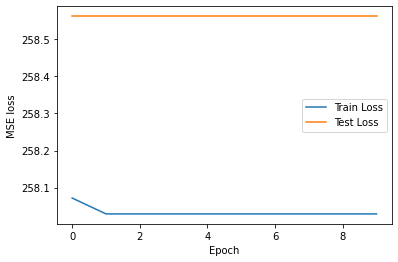

Epoch 1


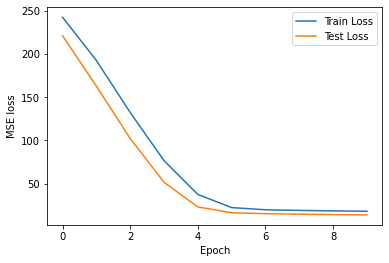

Epoch 2


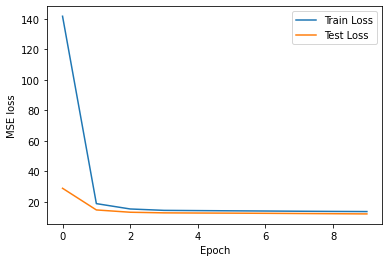

Epoch 3


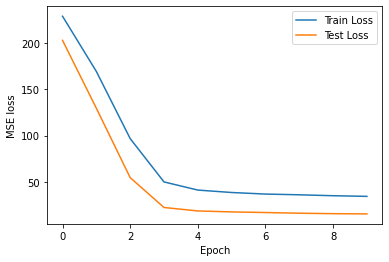

Epoch 4


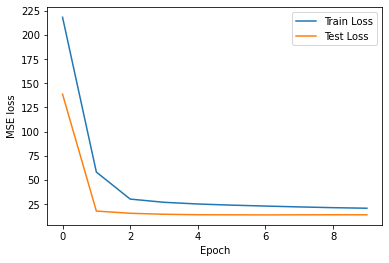

Epoch 5


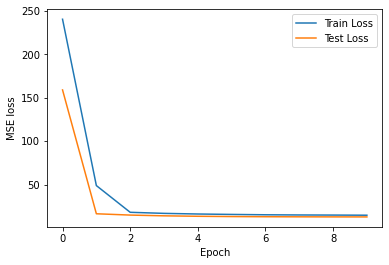

Epoch 6


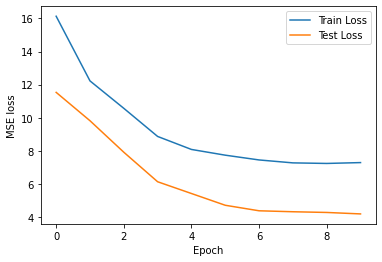

Epoch 7


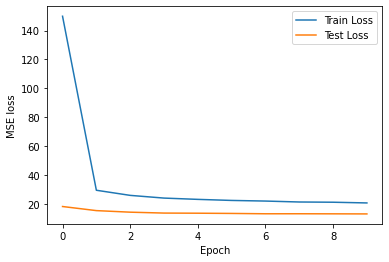

Epoch 8


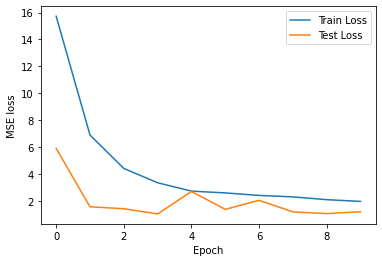

Epoch 9


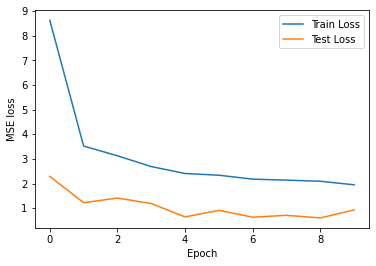

Epoch 10


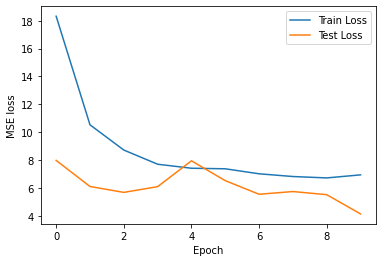

Epoch 11


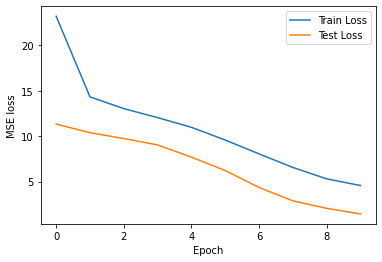

Epoch 12


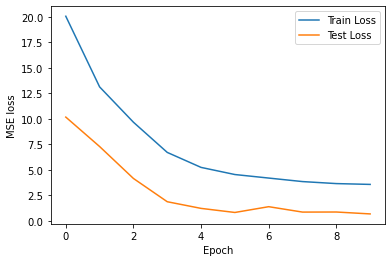

Epoch 13


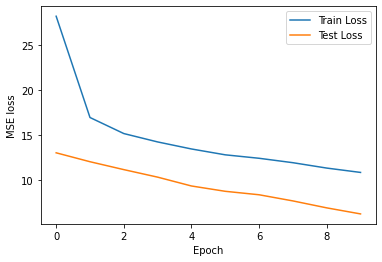

Epoch 14


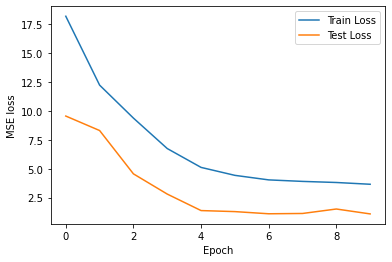

Epoch 15


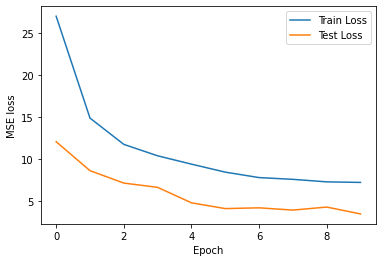

In [127]:
for i in range(len(ow.train_loss_list)):
    print("Epoch", i)
    d = [(ow.train_loss_list[i],"Train Loss"), (ow.test_loss_list[i], "Test Loss")]
    u.quick_loss_plot(d)
    

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15


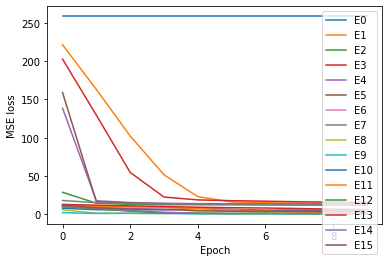

In [128]:
dd = []
for i in range(len(ow.test_loss_list)):
    print("Epoch", i)
    dd += [(ow.test_loss_list[i], f"E{i}")]
u.quick_loss_plot(dd)

### CNN Model

0 0.5569111000954523
1 0.12257263474655217
2 0.06894927434656635
3 0.11621779421957418
4 0.08740203377219792
5 0.0241287493192499
6 0.06900624040617111
7 0.015223120807202974
8 0.010218111183096805
9 0.01530297049372923
10 0.025769036937153877
11 0.010571942657835428
12 0.013141902241282345
13 0.005695126148098557
14 0.00685029002854498
15 0.004707452052519826
16 0.004704515476750563
17 0.01624553749234912
18 0.004262287070526951
19 0.003821845175672733


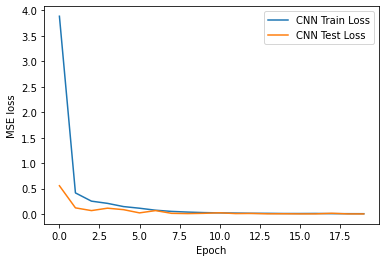

In [35]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnn = DNA_CNN(seq_len)
mer8motif_model_cnn.to(device)

mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnn, 
    lr=0.01
)

# to plot loss
mer8motif_cnn_data_label = list(zip([mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer8motif_cnn_data_label)

In [36]:
dna = "GGGGGGGG"
dna_oh = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).float().to(device)
mer8motif_model_cnn(dna_oh)

tensor([[13.9944]], device='cuda:0', grad_fn=<AddmmBackward>)

In [37]:
quick_test8(mer8motif_model_cnn, oracle_8mer_motif)

AAAAAAAA: pred:19.948 actual:20.000 (0.052)
CCCCCCCC: pred:17.030 actual:17.000 (-0.030)
GGGGGGGG: pred:13.994 actual:14.000 (0.006)
TTTTTTTT: pred:10.917 actual:11.000 (0.083)

AACCAACA: pred:18.894 actual:18.875 (-0.019)
CCGGCGCG: pred:4.891 actual:5.500 (0.609)
GGGTAAGG: pred:15.124 actual:15.125 (0.001)
TTTCGTTT: pred:12.106 actual:12.125 (0.019)
TGTAATAC: pred:15.504 actual:15.500 (-0.004)

TATAAAAA: pred:27.787 actual:27.750 (-0.037)
CCTATCCC: pred:25.902 actual:25.875 (-0.027)
GTATGGGG: pred:24.065 actual:24.000 (-0.065)
TTTATTTT: pred:22.084 actual:22.125 (0.041)

AAGCGAAA: pred:8.170 actual:8.125 (-0.045)
CGCGCCCC: pred:6.161 actual:6.250 (0.089)
GGGCGGGG: pred:4.280 actual:4.375 (0.095)
TTGCGTTT: pred:2.875 actual:2.500 (-0.375)

ATATGCGA: pred:15.422 actual:15.875 (0.453)
TGCGTATT: pred:13.912 actual:13.625 (-0.287)



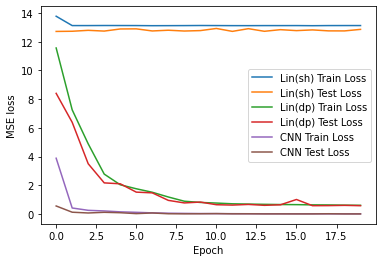

In [38]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label
)

In [39]:
def parity_pred(models, seqs, oracle,task,alt=True):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model in models:
        print(f"Running {model_name}")
        data = []
        for dna in seqs:
            s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(device)
            actual = oracle[dna]
            pred = model(s.float())
            data.append([dna,actual,pred.item()])
        df = pd.DataFrame(data, columns=['seq','truth','pred'])
        pearson = df['truth'].corr(df['pred'])
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            u.alt_parity_plot(model_name, df, pearson,task)
        u.parity_plot(model_name, df, pearson)

    return dfs

Running LinearShallow_8mer


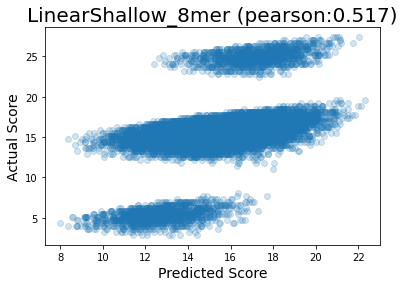

Running LinearDeep_8mer


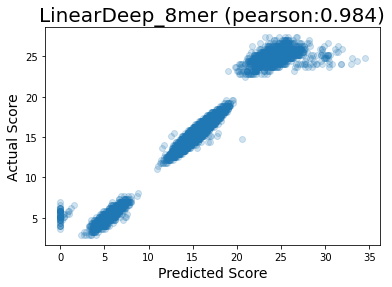

Running CNN_8mer


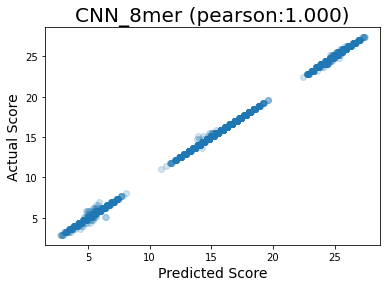

In [40]:
models = [
    ("LinearShallow_8mer",mer8motif_model_lin_s),
    ("LinearDeep_8mer",mer8motif_model_lin_d),
    ("CNN_8mer",mer8motif_model_cnn),
]

seqs = mer8motif_test_df['seq'].values
task = "TATGCGmotif"

dfs = parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)

# inspect

# 8mer model cnn

In [43]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()

Total convolutional layers: 1


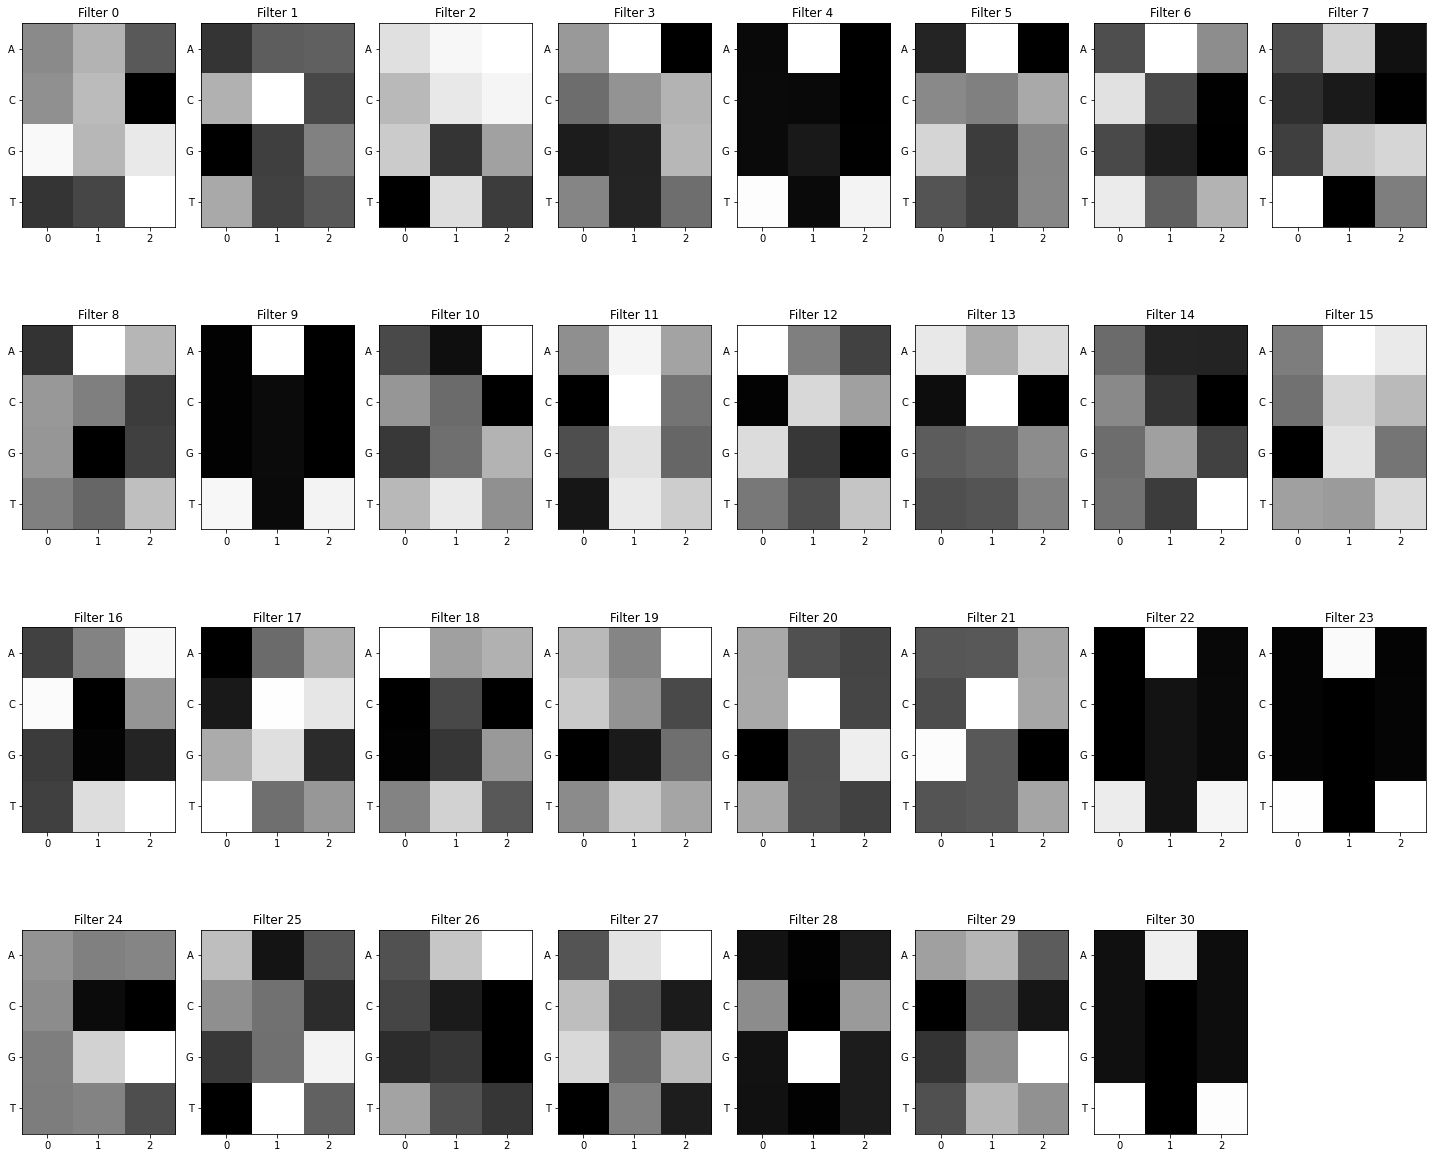

In [44]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(mer8motif_model_cnn)
view_filters(model_weights)

In [48]:
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(device)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

In [46]:
#train_seqs = list(mer8motif_train_df['seq'])# still using mer6 seqs is ok cuz just getting activations!
seqs8_5k = u.downselect_list(seqs8,5000)

In [49]:
filter_activations = get_filter_activations(seqs8_5k, conv_layers[0])

Num filters 31
filt_width 3
Running seq AGGTCGGA
Running seq AAAAACAG
Running seq TTGTGGAG
Running seq AGCTAGGC
Running seq AACTTATA
Running seq GGCAGCCC
Running seq TTAGCCTA
Running seq GCAACGCC
Running seq ATGTCTGT
Running seq CGGCACGT
Running seq CGCCTTAC
Running seq GTAAATAA
Running seq TTGGGGCA
Running seq TAAGCAGA
Running seq GGCATCAA
Running seq GACGACAG
Running seq AATACCTA
Running seq GCGTTCGT
Running seq AGCGTACC
Running seq TGCGTCAA
Running seq AAACCTTG
Running seq TCAGCGAG
Running seq AGCAAGGT
Running seq GTATCCCA
Running seq CTAACTAA
Running seq AACAAACC
Running seq AGCGCCCA
Running seq GCTCCGTA
Running seq ACAGGCGA
Running seq TCCTGAGC
Running seq GAGTAGTG
Running seq AACCTTTA
Running seq GGGTTCCG
Running seq GGTACTGC
Running seq AGCCTTTT
Running seq TCCTCACT
Running seq CTCGCCAT
Running seq ACGTATCG
Running seq TCGGCTAT
Running seq CGGATGAT
Running seq CGCTCCGA
Running seq AAATGTCA
Running seq AAGGTTTC
Running seq GAGGAGCT
Running seq TCCCATAT
Running seq CATCTTGA
Runnin

Running seq GGGGAATA
Running seq CCTGGAAT
Running seq GGCTCAAA
Running seq GATTGCAT
Running seq CTTAGGTG
Running seq CGGCAAAT
Running seq CTGAAAAT
Running seq TAGCAGAT
Running seq CCGTCGCG
Running seq GTTACGTC
Running seq CTTTCAAA
Running seq GCCGGTAA
Running seq TAAGGGAC
Running seq AAAGCTCG
Running seq CGCTTCCC
Running seq AGCATGGA
Running seq CTATTAGG
Running seq GGCCAAGA
Running seq CACGGACT
Running seq ATCGTCTA
Running seq GGGCCTGT
Running seq CCGGATCG
Running seq AGTCGAGC
Running seq CCTGCTCT
Running seq AGGTACGA
Running seq ATTCCTTC
Running seq CCTCGTCG
Running seq CAACAGGA
Running seq TTAGCTGC
Running seq ACCGCGTG
Running seq GATCTAGT
Running seq CATGAGGT
Running seq CCGGGACC
Running seq TTCAAGGA
Running seq AGGCCTTG
Running seq CGGCTAAT
Running seq TGCTTTTC
Running seq TGGAGTTT
Running seq TGTTAGAG
Running seq TGCCAGAA
Running seq GGCACAGG
Running seq GAAGCGTG
Running seq ACACTATA
Running seq ACACGACT
Running seq CATACTTG
Running seq CTATCAAC
Running seq TCTTACGG
Running seq C

Running seq CACACATT
Running seq ATTATGGG
Running seq TAAAGCAC
Running seq AGCGACTA
Running seq CCCGAAAA
Running seq AGCTCGAA
Running seq TTGGTTAT
Running seq TACTATCT
Running seq CCATGAGA
Running seq AGGCCTGT
Running seq AGGCGAAG
Running seq GGTAAGGG
Running seq CTTTGAGT
Running seq CAGGCAGC
Running seq ACGTTAGC
Running seq TACATCTC
Running seq GGAAATGC
Running seq TTAACTCA
Running seq GGTAGCGT
Running seq TTGCTGCG
Running seq GACCGCCA
Running seq TTTAGGGT
Running seq AACAGAAG
Running seq GGGCTACT
Running seq GCTGACGT
Running seq TTTGTCCA
Running seq TTATCACT
Running seq TGATTACT
Running seq TGTAGCTT
Running seq GTGGACCC
Running seq CATCTTAT
Running seq ACGTACCG
Running seq TTTCGTTC
Running seq TCTTTCTT
Running seq GGGTTTCT
Running seq TGGGTATT
Running seq GGAGGTGG
Running seq CGTAAGGG
Running seq GACAACGG
Running seq CTAAGCTG
Running seq CCCCATAT
Running seq CTCTAGGA
Running seq AACTTCGG
Running seq CCAGTCTC
Running seq TGTCGGTA
Running seq ATGGATAC
Running seq TAGATGAT
Running seq C

Running seq CTACGTTC
Running seq AGCACAGA
Running seq GTAGTTAC
Running seq CTCAATGC
Running seq AGACGCCA
Running seq TTTGATTG
Running seq TCCCTGTG
Running seq CTGTCCCA
Running seq GGACGGCA
Running seq TGATCGGT
Running seq CCAGTTCA
Running seq GCTGGACT
Running seq CCTACGCC
Running seq GCCTACGA
Running seq TAAGATCG
Running seq TGAATCCA
Running seq GCTTTCGG
Running seq TTTCATTG
Running seq CTGAAATG
Running seq TACCACCC
Running seq GGTAACGT
Running seq CGTTTCGC
Running seq GGTCGAAT
Running seq GCCGGAGG
Running seq AACTTCCA
Running seq AGATCTGC
Running seq AGCCGCGA
Running seq ATGTCTCG
Running seq CGTGAATG
Running seq GCGGAACA
Running seq GGACCCTA
Running seq CGGCACCA
Running seq GCGAGTAG
Running seq GGTGGCAC
Running seq GGTTGGGT
Running seq ATCTGATC
Running seq CGACCCAA
Running seq TTGGTGAG
Running seq ACGTGAAT
Running seq GTGGGATG
Running seq TCTATAAC
Running seq AAGGCATC
Running seq TAAGCGTA
Running seq CATCAGGG
Running seq CACCCTTC
Running seq CACGGCGT
Running seq GTGCGATG
Running seq A

Running seq TTTTTTAG
Running seq CCGAATAG
Running seq AAGCCTGC
Running seq TTTCAACA
Running seq CGATCCCG
Running seq TGAGTCCT
Running seq TCAAAGAA
Running seq CCGAGAAT
Running seq CTTGTAGA
Running seq ACCTAATG
Running seq CGATTCCC
Running seq TGAGTTGA
Running seq ACACTGGT
Running seq TAGACATC
Running seq CCAAATGG
Running seq ACAACCGC
Running seq CCGGGCAA
Running seq GGCAGACT
Running seq CCCTAATC
Running seq GGCCTCAT
Running seq GATGGTGC
Running seq AACCCTGG
Running seq GCGGTACT
Running seq GTCAGCAG
Running seq CCTATCGA
Running seq CCTCCTCA
Running seq TCGCCGAC
Running seq ACAACCAT
Running seq CTCGGCAA
Running seq ATCTCGAT
Running seq GTCGAGGA
Running seq TTTACTTC
Running seq CATGCGGC
Running seq TGTACTCA
Running seq GGTGCCGT
Running seq TCACTGAC
Running seq ATTTCCAT
Running seq TGCCCATG
Running seq ACGGTTCA
Running seq CGAGGACG
Running seq ATATACTT
Running seq ATATTTTT
Running seq TATCCACA
Running seq GATCGAGT
Running seq AGATCATG
Running seq GCAGGCAC
Running seq TTGTAGAT
Running seq T

Running seq GCAGGCTA
Running seq GATGGCTC
Running seq ACATTGAT
Running seq TCTCGCTA
Running seq AGAGGGGC
Running seq TCATAGGA
Running seq CAGTCTAT
Running seq AATTAATG
Running seq TTCTCTTG
Running seq ATTCGCAA
Running seq ACTACGTC
Running seq GGGTGACA
Running seq CACGCTGA
Running seq CCTCGACC
Running seq GATCTTTG
Running seq TCGCAACG
Running seq CCTAAATC
Running seq CAGACCCC
Running seq GTGATTCA
Running seq GTTTACTC
Running seq GAAGTGTG
Running seq TTGTGTGG
Running seq ACTGTCGC
Running seq GCGGCCGA
Running seq TCATGGAA
Running seq TGCCTGCC
Running seq TCGCCGCT
Running seq CGCCTTTC
Running seq CCTAACCG
Running seq TACGGACA
Running seq CCGTCTCA
Running seq ACGACAAA
Running seq GACGGTTC
Running seq CTCCAATG
Running seq ATTTGATG
Running seq TCTAAAGA
Running seq TGAAGGCT
Running seq CGCTGACG
Running seq AAGGTCGA
Running seq TTTTGGCT
Running seq TGCCAAAT
Running seq ACATGTAG
Running seq AATCTAAT
Running seq GTCCAAAG
Running seq CAGATGGA
Running seq ACGTGTGA
Running seq ACTTGACT
Running seq T

Running seq CTCTGATG
Running seq CGCTCCCC
Running seq CTAGTTAC
Running seq ACAGGCGT
Running seq GGTACGAG
Running seq CGCAGGGC
Running seq GAACTTCT
Running seq TTACAGGT
Running seq TCGTACCG
Running seq CTCATGGG
Running seq CGTGAAGT
Running seq GAAGCCTG
Running seq TTCAATCT
Running seq TGCGTAGC
Running seq TACTCACC
Running seq GCCCCGTT
Running seq AAAACAAT
Running seq TGAAAAGA
Running seq CTGCTTAA
Running seq CTAGTAAA
Running seq GCGATTCT
Running seq AGCGTGGC
Running seq TAGCAGAA
Running seq CAGACTGT
Running seq GTCATTGT
Running seq GGAACTGA
Running seq TAAGAATC
Running seq GCGTGACC
Running seq GAGTACCC
Running seq AGGTTTTG
Running seq CCAGCGTC
Running seq CGCCCCCG
Running seq GATATTAT
Running seq CTTTTCAC
Running seq AAGTGCTC
Running seq CGCGAGGA
Running seq CTTAGTCT
Running seq AATCAGTA
Running seq GATAGTTA
Running seq CCAGGTGA
Running seq TGTATGTA
Running seq TATAGTTT
Running seq GGGGTAGA
Running seq TCCCGGCC
Running seq TACCCCTG
Running seq GAGAGGCA
Running seq TTATGACG
Running seq T

Running seq TGGGCGAC
Running seq ACATGTTC
Running seq ACGTACCA
Running seq CTCGAAGC
Running seq GACTACAT
Running seq GACCGTTG
Running seq GGTAGGAC
Running seq CATTCCCC
Running seq CGAACACG
Running seq TGGCTGAA
Running seq AACTGATC
Running seq CGGAGCTA
Running seq GACGAAGC
Running seq TCTTGCCA
Running seq TGGCCCTA
Running seq GGAATGTT
Running seq TTTCTAGT
Running seq ATGGTGTA
Running seq CATCCGCA
Running seq TGCGGAGC
Running seq GGCGCTGT
Running seq TGAGTACT
Running seq CACTCTGT
Running seq TGCGATAA
Running seq CTGTAAAA
Running seq CATTCTAT
Running seq CTAACTAG
Running seq CGCGCACG
Running seq CAGTTGCT
Running seq TTCAACAA
Running seq AATGAACA
Running seq TTGGCCCC
Running seq GACAGCTG
Running seq CCTCAATA
Running seq GACGCCCC
Running seq AAACGCGA
Running seq GGTGCGGT
Running seq ATTTAAAA
Running seq CGGTATAC
Running seq AGCCGTAG
Running seq ATGGATAA
Running seq AGGGCCAG
Running seq CACCTGGT
Running seq ACCGTGCT
Running seq TTCCTTCC
Running seq CAGAAGCC
Running seq CCACACCG
Running seq A

Running seq GTTAAATT
Running seq CGCTCGGT
Running seq GTCGCCCT
Running seq CATTATAT
Running seq ATAGGGAC
Running seq GATAGTTG
Running seq TACCGCTT
Running seq TTGACCCG
Running seq TCTGGGCG
Running seq ACCGATGT
Running seq GAAAATGA
Running seq AGATGGGG
Running seq TCCGGGCT
Running seq GGCTCTGA
Running seq GGCGTGAA
Running seq AACTGGCC
Running seq CAATCGAT
Running seq GTTGCAAC
Running seq CTTACAGT
Running seq GCTAGCAT
Running seq AGATTCAA
Running seq TAGGGGAC
Running seq CCAAGTCG
Running seq AGCGCCTC
Running seq ACCACAGG
Running seq AGCTAAAT
Running seq TAGTGACC
Running seq CAATCGGG
Running seq CACCCATG
Running seq AGCAGTTC
Running seq GAATAGCC
Running seq AGGGGACT
Running seq TGACACCC
Running seq AGAGATGC
Running seq AAGGACAC
Running seq AGCCTTAC
Running seq CAAAAGCC
Running seq TGTATTCC
Running seq TGCGATAG
Running seq AGGAAGTT
Running seq GTTAACTG
Running seq ATGCGTAG
Running seq TCGTGTTC
Running seq GTAGTACT
Running seq ACGCCTGC
Running seq TCAAGTAG
Running seq GAAGGTGG
Running seq C

Running seq ATTGGGTT
Running seq CGTCTTAA
Running seq CAGCAGGG
Running seq CGTGAATA
Running seq CCAGCCGG
Running seq CAAGCTCG
Running seq GCGTAGGT
Running seq CTGTCGAA
Running seq GGTCCAGA
Running seq GGAGCGGA
Running seq GATGCAAG
Running seq CGTAGGGT
Running seq TTTCATGG
Running seq TCAAGTCT
Running seq TATAAGTG
Running seq GGGTTCAG
Running seq TACAGCCA
Running seq CGAACACA
Running seq TCTCCCTC
Running seq CCCCAGCG
Running seq AAAGGGTG
Running seq CCCTCACC
Running seq GATTGGGA
Running seq GGAACATC
Running seq GTAGGTCA
Running seq TCTCACAT
Running seq ACTTCAGT
Running seq TGTTGGGG
Running seq AGTCGGGA
Running seq AGGCGTAG
Running seq GCCCCTGA
Running seq CCGATCGT
Running seq GGGGTTTG
Running seq TGGCACAA
Running seq TGAGCAGA
Running seq CAGAAAGA
Running seq GTGAGGTA
Running seq GTCGTCGA
Running seq TACGTTAT
Running seq GGACTCTT
Running seq GATTCAGT
Running seq AACGCCTA
Running seq TGGGAGAG
Running seq TGGCAGAG
Running seq CGCGGTAT
Running seq TCTCGAGT
Running seq CTTTAAGC
Running seq A

Running seq GTGGCCAG
Running seq ACAGTGCG
Running seq GTTAGACC
Running seq GGTGCTTC
Running seq ACGTCGGC
Running seq GTAGCCCG
Running seq GACAAGAT
Running seq TGAGATTT
Running seq CTCCAGTA
Running seq AAGTCCTA
Running seq GTACGATT
Running seq TCCTTGGG
Running seq TCGCAGCA
Running seq AGACCAGT
Running seq TGTACGAT
Running seq CCCAAAAA
Running seq TACGTGGA
Running seq TATATAGG
Running seq ATGACTAA
Running seq CTCCTAAG
Running seq TTCTTTCT
Running seq ACACTGGA
Running seq GTCCGGAT
Running seq TGCTATTA
Running seq ATTCGGCT
Running seq GGCCTAAA
Running seq GAAACCTC
Running seq AGGACCCC
Running seq ACGCAAAC
Running seq CGACATTG
Running seq TTTCGGTC
Running seq AGAAAGCA
Running seq TAAAACCG
Running seq CCTGCTTG
Running seq GTGCTTTC
Running seq AGGCGAGC
Running seq CCGTGTCG
Running seq ATTGCATG
Running seq AGGCCTAG
Running seq AGCATGAT
Running seq GAACATGA
Running seq TGCGAAGG
Running seq ACTGCACG
Running seq TACGACAT
Running seq TCCCTATG
Running seq CTGCGTGA
Running seq ATTGATCG
Running seq A

Running seq CTGCTATC
Running seq TACGCTTT
Running seq CACACCCC
Running seq TTGCCAAT
Running seq AAAAGGTA
Running seq GACAGGCG
Running seq TATCCCGG
Running seq AATGTCGT
Running seq CATACCAC
Running seq CTAGTTCT
Running seq CACGTCGC
Running seq ACGGTCCG
Running seq GGGCGGGT
Running seq GCGGCTAA
Running seq ATACGGTC
Running seq GAGGCGTG
Running seq CCAGACGA
Running seq TTTTTGGA
Running seq CCCGACTG
Running seq TAACCACG
Running seq CGTCATAG
Running seq AAGGGGCT
Running seq TTACCATC
Running seq GCTATTAC
Running seq CGGCCATG
Running seq AGAATCGG
Running seq AGACCTGA
Running seq CGTAAAGT
Running seq TTCGGAGC
Running seq AGAAAGGG
Running seq GGTTGTAC
Running seq TTTGGGCT
Running seq ATTGTTAT
Running seq CGCCTCTG
Running seq GCCTCGCA
Running seq CTTGATTA
Running seq CCTTTCCT
Running seq AGTGGTAG
Running seq TTCGCTCT
Running seq CCAGAAGC
Running seq ATTTCTCC
Running seq GTCGACTG
Running seq TACCGGGA
Running seq TATCAGCG
Running seq ATGCACCG
Running seq ATGATGAG
Running seq AGTCGCAA
Running seq T

In [50]:
def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 17))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(3))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

In [51]:
import logomaker

torch.Size([31, 4, 3])


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


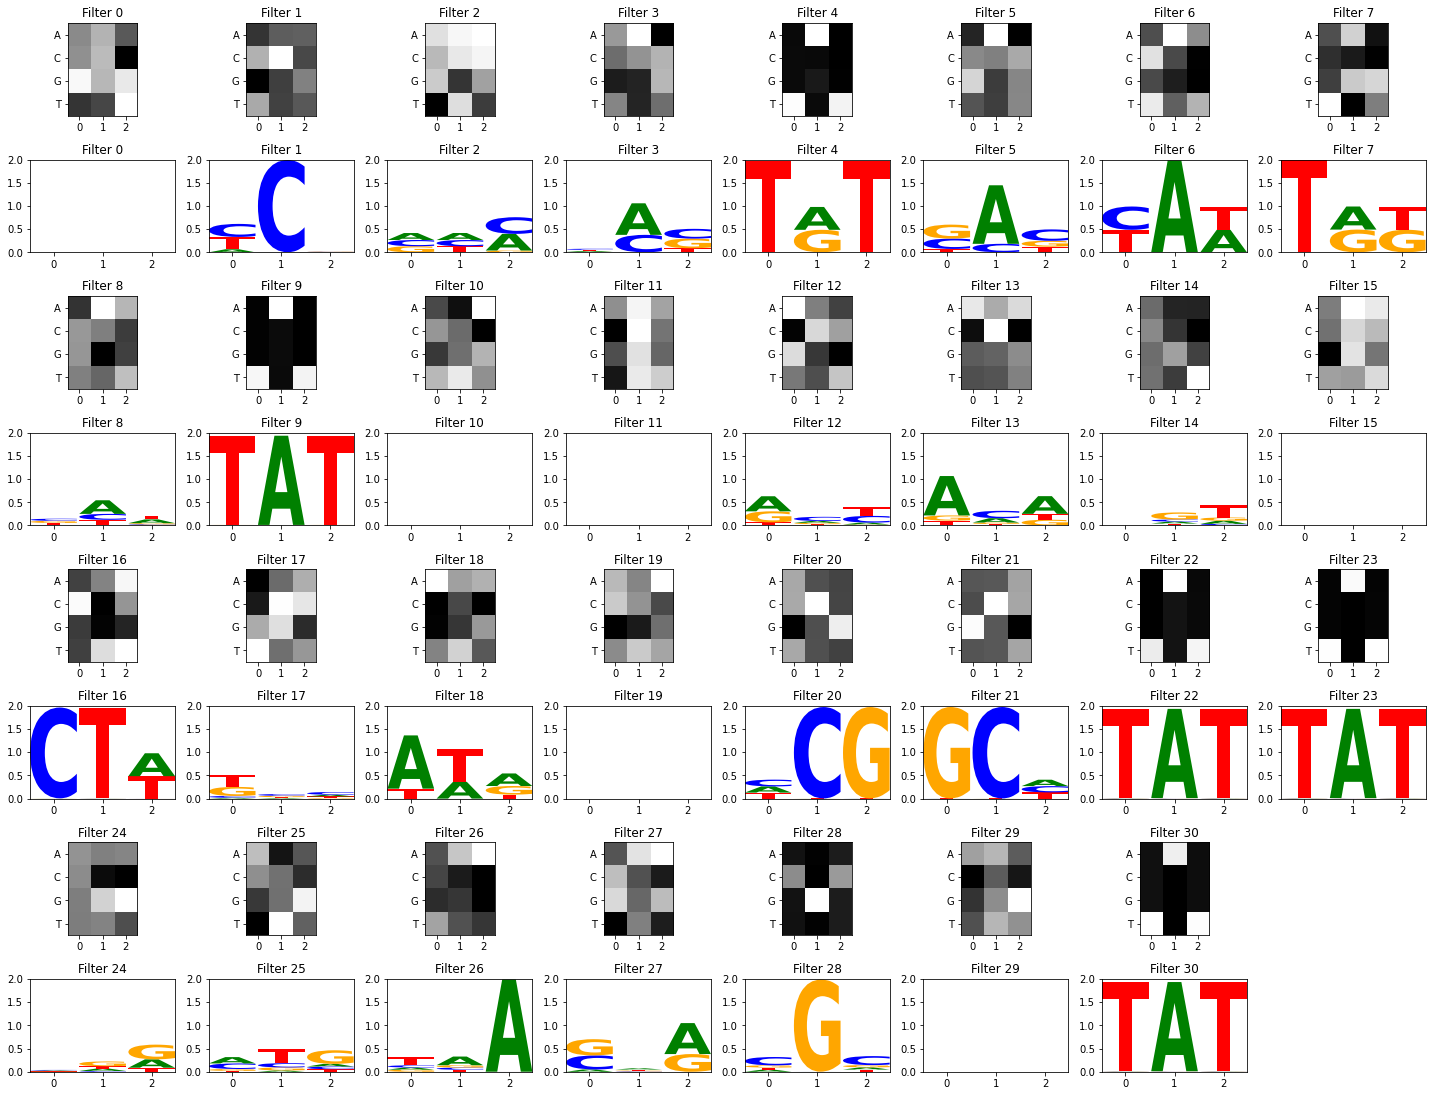

In [52]:
view_filters_and_logos(model_weights,filter_activations)

# Try LSTMs

In [46]:
# mer8motif_train_dl,\
# mer8motif_test_dl, \
# mer8motif_train_df, \
# mer8motif_test_df = u.build_dataloaders_single(mer8_motif,batch_size=11)
# change to batch size 11 so I can figure out the dimension errors

In [47]:
# class DNA_LSTM(nn.Module):
#     def __init__(self,
#                  seq_len,
#                  hidden_dim=10,
#                  layer1_dim=12,
#                  #layer2_dim=12
#                 ):
#         super().__init__()
#         self.seq_len = seq_len
#         self.hidden_dim = hidden_dim
        
#         self.hidden_init_values = None
#         self.hidden = self.init_hidden() # tuple of hidden state and cell state
        
#         self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
# #         self.fc = nn.Sequential(
# #             nn.ReLU(inplace=True),
# #             #nn.Flatten(),
# #             nn.Linear(hidden_dim, layer1_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Linear(layer1_dim, 1),
# #         )
#         self.fc = nn.Linear(hidden_dim, 1)
            
# #         self.rnn = nn.Sequential(
# #             nn.LSTM(4, hidden_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Flatten(),
# #             nn.Linear(hidden_dim, layer1_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Linear(layer1_dim, 1),
# #         ) 
    
#     def init_hidden(self):
#         if self.hidden_init_values == None:
#             self.hidden_init_values = (autograd.Variable(torch.randn(1, 1, self.hidden_dim)),
#                                        autograd.Variable(torch.randn(1, 1, self.hidden_dim)))
#         return self.hidden_init_values
#         #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

#     def forward(self, xb):
#         # WRONG? reshape view to batch_ssize x 4channel x seq_len
#         # for LSTM? reshape view to seq_len x batch_ssize x 4channel  
#         # permute to put channel in correct order
#         print("original xb.shape:", xb.shape)
#         print(xb)
#         xb = xb.view(-1,self.seq_len,4)#.permute(1,0,2) 
#         print("re-viewed xb.shape:", xb.shape) # >> 11, 8, 4
#         print(xb)
#         #print(xb[0])
#         #print("xb shape", xb.shape)

#         # ** Init hidden temp **
#         batch_size = xb.shape[0]
#         print("batch_size:",batch_size)
#         (h, c) =  (torch.zeros(1, batch_size, self.hidden_dim), torch.zeros(1, batch_size, self.hidden_dim)) 
#         # *******
        
#         lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
#         print("lstm_out",lstm_out)
#         print("^^^^^lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
#         print("lstm_out[-1] shape:",lstm_out[-1].shape)
#         print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape)
#         print("hidden len:",len(self.hidden))
#         print("hidden[0] shape:", self.hidden[0].shape)
#         print("hidden[0][-1] shape:", self.hidden[0][-1].shape)
#         print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape)
        
#         print("*****")
#         A = lstm_out[-1][-1]
#         B = self.hidden[0][-1][-1]
#         print("lstm_out[-1][-1]:",A)
#         print("self.hidden[0][-1][-1]",B)
#         print("==?", A==B)
#         print("*****")
        
#         #linear_in = lstm_out.contiguous().view(-1, self.hidden_dim)
#         #print("Linear In shape:", linear_in.shape)
#         #print("self.hidden",self.hidden)
#         #print(self.hidden[1].shape)
#         #out = self.fc(linear_in)
#         out = self.fc(lstm_out)
#         #print("out",out)
#         print("LSTM->FC out shape:",out.shape)
#         return out

In [56]:
class DNA_LSTM(nn.Module):
    def __init__(self,seq_len,hidden_dim=10):
        super().__init__()
        self.seq_len = seq_len

        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            

    
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim).to(device), 
                        torch.zeros(1, batch_size, self.hidden_dim).to(device))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

    def forward(self, xb,verbose=False):
        if verbose:
            print("original xb.shape:", xb.shape)
            print(xb) # 11 x 32
        
        # make the one-hot nucleotide vectors group together
        xb = xb.view(-1,self.seq_len,4) 
        if verbose:
            print("re-viewed xb.shape:", xb.shape) # >> 11 x 8 x 4
            print(xb)

        # ** Init hidden/cell states?? **
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
         
        # *******
        
        lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
        if verbose:
            #print("lstm_out",lstm_out)
            print("lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
            print("lstm_out[-1] shape:",lstm_out[-1].shape) # >> 8 x 10
            print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape) # 10

            print("hidden len:",len(self.hidden)) # 2
            print("hidden[0] shape:", self.hidden[0].shape) # >> 1 x 11 x 10
            print("hidden[0][-1] shape:", self.hidden[0][-1].shape) # >> 11 X 10
            print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape) # >> 10

            print("*****")
            # These vectors should be the same, right?
            A = lstm_out[-1][-1]
            B = self.hidden[0][-1][-1]
            print("lstm_out[-1][-1]:",A)
            print("self.hidden[0][-1][-1]",B)
            print("==?", A==B)
            print("*****")
        
        # attempt to get the last layer from each last position of 
        # all seqs in the batch? IS this the right thing to get?
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        #last_layer = lstm_out[-1][-1].unsqueeze(0) # this was [10X1]? led to FC outoput being [1]?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)   
                                                
        return out

In [57]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_lstm = DNA_LSTM(seq_len)
mer8motif_model_lstm.to(device)
mer8motif_model_lstm

DNA_LSTM(
  (rnn): LSTM(4, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [58]:
mer8motif_train_losses_lstm,\
mer8motif_test_losses_lstm = run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lstm
)


0 6.260159874834555
1 0.4496247885378716
2 0.16716840660138704
3 0.14072362282863332
4 0.09278451318380547
5 0.06707288449056627
6 0.05554063760076965
7 0.049598241726639646
8 0.04401551350474592
9 0.04058236211508758
10 0.03338368776578912
11 0.033038280472700216
12 0.02830174467479483
13 0.02681118899403293
14 0.028525896199216097
15 0.024077181333923517
16 0.023232243443398175
17 0.020895900246874804
18 0.019443034697372352
19 0.020847224560822025


In [59]:
quick_test8(mer8motif_model_lstm, oracle_8mer_motif)

AAAAAAAA: pred:19.909 actual:20.000 (0.091)
CCCCCCCC: pred:16.879 actual:17.000 (0.121)
GGGGGGGG: pred:12.330 actual:14.000 (1.670)
TTTTTTTT: pred:10.912 actual:11.000 (0.088)

AACCAACA: pred:18.890 actual:18.875 (-0.015)
CCGGCGCG: pred:5.398 actual:5.500 (0.102)
GGGTAAGG: pred:15.167 actual:15.125 (-0.042)
TTTCGTTT: pred:12.099 actual:12.125 (0.026)
TGTAATAC: pred:15.643 actual:15.500 (-0.143)

TATAAAAA: pred:27.015 actual:27.750 (0.735)
CCTATCCC: pred:25.709 actual:25.875 (0.166)
GTATGGGG: pred:24.107 actual:24.000 (-0.107)
TTTATTTT: pred:22.688 actual:22.125 (-0.563)

AAGCGAAA: pred:7.827 actual:8.125 (0.298)
CGCGCCCC: pred:6.565 actual:6.250 (-0.315)
GGGCGGGG: pred:4.407 actual:4.375 (-0.032)
TTGCGTTT: pred:2.620 actual:2.500 (-0.120)

ATATGCGA: pred:16.438 actual:15.875 (-0.563)
TGCGTATT: pred:14.069 actual:13.625 (-0.444)



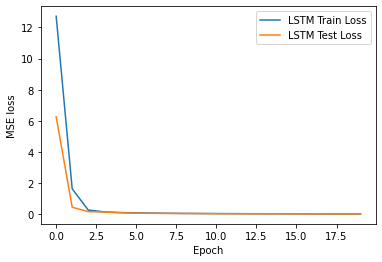

In [60]:
mer8motif_lstm_data_label = list(zip([mer8motif_train_losses_lstm,mer8motif_test_losses_lstm], ['LSTM Train Loss','LSTM Test Loss']))
u.quick_loss_plot(mer8motif_lstm_data_label)

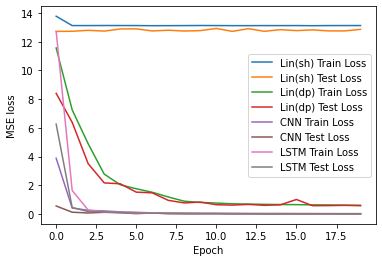

In [62]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_lstm_data_label
)

# Try CNN + LSTM

In [63]:
class DNA_CNNLSTM(nn.Module):
    def __init__(self,
                 seq_len,
                 hidden_dim=10,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
        ) 
        
        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(num_filters, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim).to(device), 
                        torch.zeros(1, batch_size, self.hidden_dim).to(device))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)

    def forward(self, xb, verbose=False):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        if verbose:
            print("xb reviewed shape:",xb.shape)

        cnn_out = self.conv_net(xb)
        if verbose:
            print("CNN out shape:",cnn_out.shape)
        cnn_out_perm = cnn_out.permute(0,2,1)
        if verbose:
            print("CNN permute out shape:",cnn_out_perm.shape)
        
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
        
        lstm_out, self.hidden = self.rnn(cnn_out_perm, (h,c)) # should this get H and C?
        
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)        
        
        return out

In [64]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnnlstm = DNA_CNNLSTM(seq_len)
mer8motif_model_cnnlstm.to(device)
mer8motif_model_cnnlstm

DNA_CNNLSTM(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
  )
  (rnn): LSTM(32, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [65]:
mer8motif_train_losses_cnnlstm,\
mer8motif_test_losses_cnnlstm = run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnnlstm, 
)


0 0.07196659167053625
1 0.031667309376102216
2 0.017119646810827453
3 0.011509698197438285
4 0.008992252712792935
5 0.007147299186262974
6 0.0057655125174186925
7 0.005108086138684011
8 0.004080067886267188
9 0.003953143811440021
10 0.003432509028998286
11 0.0030785402910923003
12 0.0028664747383019555
13 0.0025103538767436255
14 0.0024313272653820207
15 0.002229692030768827
16 0.0022397079033929733
17 0.0020456290811754004
18 0.00197046722455099
19 0.001859434334366321


AAAAAAAA: pred:19.967 actual:20.000 (0.033)
CCCCCCCC: pred:17.006 actual:17.000 (-0.006)
GGGGGGGG: pred:13.971 actual:14.000 (0.029)
TTTTTTTT: pred:10.942 actual:11.000 (0.058)

AACCAACA: pred:18.863 actual:18.875 (0.012)
CCGGCGCG: pred:5.509 actual:5.500 (-0.009)
GGGTAAGG: pred:15.146 actual:15.125 (-0.021)
TTTCGTTT: pred:12.164 actual:12.125 (-0.039)
TGTAATAC: pred:15.470 actual:15.500 (0.030)

TATAAAAA: pred:27.455 actual:27.750 (0.295)
CCTATCCC: pred:25.907 actual:25.875 (-0.032)
GTATGGGG: pred:23.904 actual:24.000 (0.096)
TTTATTTT: pred:22.148 actual:22.125 (-0.023)

AAGCGAAA: pred:8.028 actual:8.125 (0.097)
CGCGCCCC: pred:6.278 actual:6.250 (-0.028)
GGGCGGGG: pred:4.406 actual:4.375 (-0.031)
TTGCGTTT: pred:2.617 actual:2.500 (-0.117)

ATATGCGA: pred:15.830 actual:15.875 (0.045)
TGCGTATT: pred:13.563 actual:13.625 (0.062)



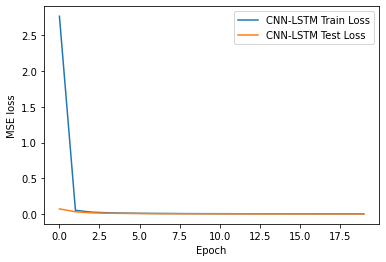

In [66]:
quick_test8(mer8motif_model_cnnlstm, oracle_8mer_motif)

mer8motif_cnnlstm_data_label = list(zip([mer8motif_train_losses_cnnlstm,mer8motif_test_losses_cnnlstm], ['CNN-LSTM Train Loss','CNN-LSTM Test Loss']))
u.quick_loss_plot(mer8motif_cnnlstm_data_label)

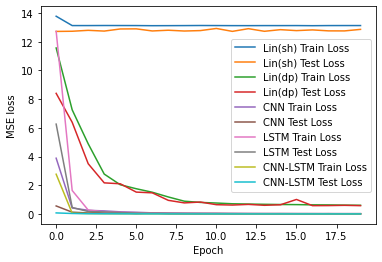

In [67]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_lstm_data_label + \
    mer8motif_cnnlstm_data_label
)

Running LinearShallow_8mer


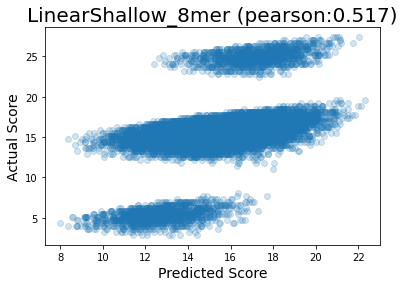

Running LinearDeep_8mer


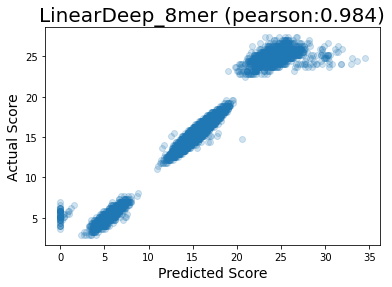

Running CNN_8mer


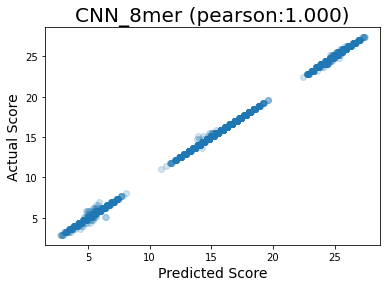

Running LSTM_8mer


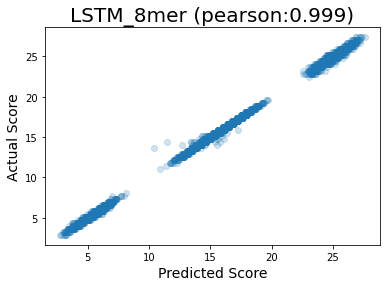

Running CNN+LSTM_8mer


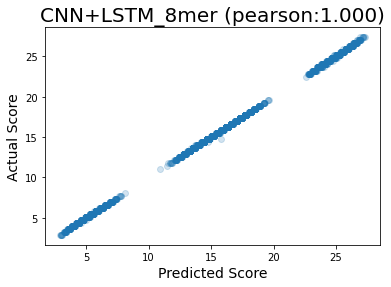

In [68]:
models = [
    ("LinearShallow_8mer",mer8motif_model_lin_s),
    ("LinearDeep_8mer",mer8motif_model_lin_d),
    ("CNN_8mer",mer8motif_model_cnn),
    ("LSTM_8mer",mer8motif_model_lstm),
    ("CNN+LSTM_8mer",mer8motif_model_cnnlstm),
]

seqs = mer8motif_test_df['seq'].values
task = "TATGCGmotif"

#dfs = u.parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)
dfs = parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)